In [1]:
import os
import pickle
import pandas as pd
import pathlib
try:
    path = pathlib.Path(__file__).parent.resolve()
except NameError:
    path = pathlib.Path().resolve()

def save_pkl(item, fname):
    sn = fname
    with open(sn, 'wb') as handle:
        pickle.dump(item, handle) #, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved at: {sn}')
    return None
# return None

def load_pkl(fname):
    with open(fname, 'rb') as handle:
        ans = pickle.load(handle)
    # print(f'Loaded from: {fname}')
    return ans

def get_folders(char = 'tmp'):
    dirlist = os.listdir(path = path)
    folders = []
    for i in dirlist:
        if char in i:
            folders.append(i)
    return folders

def get_df(folder):
    files = os.listdir(path = folder)
    file = files[0]
    df_list = []
    for file in files:
        try:
            df_list.append(pd.concat(load_pkl(folder + '/' + file)))
        except ValueError:
            print(f"!!!!!!! WARNING WARNING: {folder + '/' + file} is EMPTY !!!!!!!")
            pass
    # df = pd.concat([pd.concat(load_pkl(folder + '/' + file)) for file in files]).reset_index(drop = True)
    try:
        df = pd.concat(df_list).reset_index(drop = True)
    except ValueError:
        df = None
        print(f'!!!!! WARNING WARNING: {folder} is EMPTY !!!!!')
    return df

def get_minimums(char = 'tmp'):
    folders = get_folders(char)

    results = {}
    for i in folders:
        results[i] = get_df(i)

    keys = list(results.keys())

    minimums = {}
    for k in keys:
        try:
            df = results[k]
            minimums[k] = df[df['obj'] == df['obj'].min()]
        except TypeError:
            minimums[k] = None
            print(f'{k} is empty.')
    return minimums

In [2]:
import numpy as np
import random
import scipy.integrate as scp
import numpy.random as rnd
import time
import matplotlib.pyplot as plt
import numpy.random as rnd
import copy
from matplotlib.pyplot import figure
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd
import pickle
import scipy.stats
from math import comb

In [3]:
dirlist = os.listdir(path = path)

In [4]:
dirlist

['data', 'data_treatment.ipynb', 'tmp6', 'tmp7', 'tmp8']

In [5]:
xobs1 = load_pkl('data/xobs1.pkl')
xobs2 = load_pkl('data/xobs2.pkl')
xobs3 = load_pkl('data/xobs3.pkl')
xobs4 = load_pkl('data/xobs4.pkl')
Fcn   = load_pkl('data/Fcn.pkl')
tf_N  = load_pkl('data/tf_N.pkl')
operation_con = load_pkl('data/operation_con.pkl')

tt1 = load_pkl('data/tt1.pkl')
std_value1 = load_pkl('data/std_value1.pkl')
std_value2 = load_pkl('data/std_value2.pkl')
std_value3 = load_pkl('data/std_value3.pkl')
std_value4 = load_pkl('data/std_value4.pkl')
data_init = load_pkl('data/data_init.pkl')

operation_con1 = operation_con[0]
operation_con2 = operation_con[1]
operation_con3 = operation_con[2]
operation_con4 = operation_con[3]

Fcn1 = Fcn[0] 
Fcn2 = Fcn[1]
Fcn3 = Fcn[2]  
Fcn4 = Fcn[3]

tf    = 16.*24.
steps_= 16
dt    = tf/steps_


num_N = 4
tf_N  = tf/(num_N)
dstep_N = int(tf_N/dt)


In [6]:

std_value1 

array([0.03597973, 5.94358872])

In [7]:
std1 =  np.ones([2,17])

In [8]:
std1[0,:] = std_value1[0] 
std1[1,:] = std_value1[1] 

In [9]:
operation_con

array([[1.00e-01, 1.00e+02],
       [1.50e-01, 1.50e+02],
       [1.75e-01, 1.25e+02],
       [1.25e-01, 1.75e+02]])

In [10]:
minimums = get_minimums()
# save_pkl(minimums, 'minimums.pkl')

In [11]:
for k in list(minimums.keys()):
    print(k, minimums[k]['obj'].iloc[0])

tmp6 593.4600169256994
tmp7 591.8971154355318
tmp8 588.8336430484492


In [12]:
nll_list = [minimums['tmp6']['obj'].to_list()[0],minimums['tmp7']['obj'].to_list()[0],minimums['tmp8']['obj'].to_list()[0]]

#obj_list = [minimums['tmp2']['obj'].to_list()[0],minimums['tmp3']['obj'].to_list()[0],minimums['tmp4']['obj'].to_list()[0],minimums['tmp5']['obj'].to_list()[0],minimums['tmp6']['obj'].to_list()[0],minimums['tmp7']['obj'].to_list()[0],minimums['tmp8']['obj'].to_list()[0]]

In [13]:
nll_list

[593.4600169256994, 591.8971154355318, 588.8336430484492]

In [14]:
nd1 = xobs1.shape[1]
nd2 = xobs2.shape[1]
nd3 = xobs3.shape[1]
nd4 = xobs4.shape[1]

In [15]:
total_nd = nd1 + nd2 + nd3 + nd4

In [16]:
x_max = np.max(np.array([xobs1[0],xobs2[0],xobs3[0],xobs4[0]]))
n_max = np.max(np.array([xobs1[1],xobs2[1],xobs3[1],xobs4[1]]))


In [19]:
def AIC_obj(NLL,sp):
    n_p = np.sum(sp)
    AIC = (2*NLL) + 2*n_p

    return AIC

def AICC_obj(NLL,sp):
    n_p = np.sum(sp)
    AICc = (2*NLL) + 2*n_p + (2*n_p**2 + 2*n_p)/((total_nd) - n_p -1)

    return AICc


def BIC_obj(NLL,sp):
    n_p = np.sum(sp)
    BIC = (2*NLL) + (n_p*np.log(total_nd))

    return BIC
def HQC_obj(NLL,sp):
    n_p = np.sum(sp)
    HQC = (2*NLL) + 2*n_p*np.log(np.log(total_nd))

    return HQC


In [20]:
def string_to_list_of_ints(s):
    return [int(char) for char in s]

In [21]:
sp_list = [string_to_list_of_ints(minimums['tmp6']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp7']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp8']['parameters'].iloc[0])]

#sp_list = [string_to_list_of_ints(minimums['tmp2']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp3']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp4']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp5']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp6']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp7']['parameters'].iloc[0]),string_to_list_of_ints(minimums['tmp8']['parameters'].iloc[0])]

In [22]:
sp_list

[[1, 1, 1, 1, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 1, 1, 1, 0, 1],
 [1, 0, 1, 1, 1, 1, 1, 1, 1]]

In [23]:
AIC = []

for i in range(len(sp_list)):
    AIC.append(AIC_obj(nll_list[i],sp_list[i]))

In [24]:
AIC 

[1198.9200338513988, 1197.7942308710635, 1193.6672860968984]

In [25]:
BIC = []

for i in range(len(sp_list)):
    BIC.append(BIC_obj(nll_list[i],sp_list[i]))

In [26]:
BIC

[1214.786379246247, 1216.304967165053, 1214.8224132900293]

In [25]:
#HQC = []

#for i in range(len(sp_list)):
#    HQC.append(HQC_obj(obj_list[i],sp_list[i]))

In [27]:
AICC = []

for i in range(len(sp_list)):
    AICC.append(AICC_obj(nll_list[i],sp_list[i]))

In [28]:
def normalization(data):
    normailseddata = []
    xmin = min(data)
    xmax = max(data)
    for i in range(len(data)):
        normailseddata.append((data[i]-xmin)/(xmax-xmin))
    return normailseddata

In [29]:
nls = normalization(nll_list)
nAIC =normalization(AIC)
nBIC =normalization(BIC)
#nHQC =normalization(HQC) 
nAICC =normalization(AICC) 

In [30]:
index_min_newnAIC = np.argmin(np.array(nAIC))
index_min_newnBIC = np.argmin(np.array(nBIC))
index_min_newnAICC = np.argmin(np.array(nAICC))
index_min_newnls = np.argmin(np.array(nls))

nAIC[index_min_newnAIC] = 1e-5
# nval[index_min_nval] = 1e-5
nBIC[index_min_newnBIC] = 1e-5
nAICC[index_min_newnAICC] = 1e-5
nls[index_min_newnls] = 1e-5

In [31]:
nAIC

[1.0, 0.7856735116643088, 1e-05]

In [32]:
nBIC

[1e-05, 1.0, 0.023728651687611232]

In [33]:
nAICC

[1.0, 0.8207415012640342, 1e-05]

In [34]:
sp_name_list = ['6','7','8']

# sp_name_list = ['np=2','np=3','np=4','np=5','np=6','np=7','np=8']

C:\Users\wangh\AppData\Local\Temp\ipykernel_23992\1340867691.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sp_name_list)


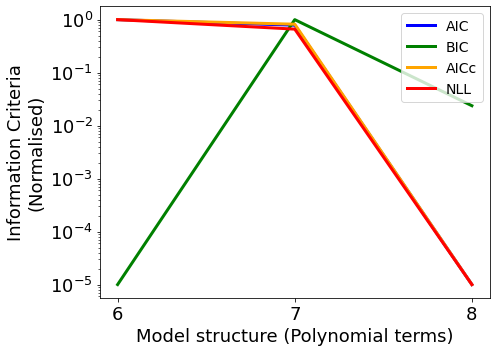

In [35]:
fontsize = 18
linewidth = 3  
fig, ax = plt.subplots(figsize=(7, 5))

# plt.plot(sp_name_list,nAIC,label = 'AIC')
ax.plot(sp_name_list,nAIC,label = 'AIC',color = 'blue',linewidth=linewidth)
ax.plot(sp_name_list,nBIC,label = 'BIC',color = 'green',linewidth=linewidth)
ax.plot(sp_name_list,nAICC,label = 'AICc',color = 'orange',linewidth=linewidth)
# ax.plot(sp_name_list,nval,label = 'Validation',color = 'purple')

ax.plot(sp_name_list,nls,label = 'NLL',color = 'red',linewidth=linewidth)
ax.set_yscale('log')
ax.legend(loc="upper right", fontsize=fontsize-4 )
ax.set_ylabel('Information Criteria\n(Normalised)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize )
# ax.set_xticklabels(sp_name_list, rotation=40, ha = 'right')
ax.set_xticklabels(sp_name_list)
# for i in ax.get_xticklabels():

#    if i.get_text() == '3':
#       i.set_fontweight('bold')

#    if i.get_text() == '4':
#       i.set_fontweight('bold')
ax.set_xlabel('Model structure (Polynomial terms)', fontsize=fontsize)
plt.tight_layout()
# plt.ylabel('Normalised value')
# plt.xticks(rotation=45)
# plt.xlabel('model structure')
# plt.tight_layout()
# plt.ylim([0, 0.01])
# plt.xlim([4, 8])
# plt.savefig('model selection NN algae.svg')
plt.savefig('model selection round2.svg')
plt.show()

In [35]:
# CHECKED UNTIL HERE -------------------------------------

In [36]:
def allparametervalues(dataframe,sp,Fcn):
    h_p = {'p0': dataframe['p0'].to_list()[0], 'p1': dataframe['p1'].to_list()[0], 'p2' : dataframe['p2'].to_list()[0], 'p3':dataframe['p3'].to_list()[0],'p4': dataframe['p4'].to_list()[0], 'p5': dataframe['p5'].to_list()[0], 'p6' : dataframe['p6'].to_list()[0], 'p7':dataframe['p7'].to_list()[0],'p8': dataframe['p8'].to_list()[0], 'p9': dataframe['p9'].to_list()[0],'u_d': dataframe['u_d'].to_list()[0],'Y_nx': dataframe['Y_nx'].to_list()[0],'sp':sp,'Fcn':Fcn}
    return h_p

In [37]:
# Hybrid model structure #
class hybrid_model:
    
    def __init__(self,parameters):
        self. parameters = parameters
        # Object variable definitions

        self.parameters = parameters
        # a = np.zeros(1)
        
        # if type(parameters) == type(a):
        #     parameters = pd.DataFrame([parameters], columns = parameter_names)
    
    def model(self, t, state):
        params = self.parameters
        
        #state vectors
        x = state[0]
        n = state[1]

        # FCn    = params['FCn']
        #parameters

        p0 = params['p0']
        p1 = params['p1']
        p2 = params['p2']
        p3 = params['p3']
        p4 = params['p4']
        p5 = params['p5']
        p6 = params['p6']
        p7 = params['p7']
        p8 = params['p8']
        p9 = params['p9']

        u_d    = params['u_d']
        sp     = params['sp']
        Y_nx    = params['Y_nx']
        Fcn    = params['Fcn']
        # x_max   = params['x_max']
        # n_max   = params['n_max']

        
        #algebraic equations
        u = p0 + sp[0]*p1 * x/x_max + sp[1]*p2 * n/n_max + sp[2]*p3 *(x/x_max)**2 +  sp[3]*p4*x/x_max*n/n_max + sp[4]*p5*(n/n_max)**2 + sp[5]*p6*(x/x_max)**3 + sp[6]*p7 * (x/x_max)**2*n/n_max + sp[7]*p8 *x/x_max*(n/n_max)**2 + sp[8]*p9 *(n/n_max)**3
        #variable rate equations
        dev_x  = u * x - u_d*x**2
        
        dev_n  = - Y_nx * u * x + Fcn
        return np.array([dev_x,dev_n],dtype='float64')
        
        # Simulation
        
    def simulation(self, steps, tf, x0):

        # external defination

        self.x0, self.tf = x0, tf

        #internal definations
        model = self.model
        dt    = tf/(steps)

        #compile state trajectories

        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))

        #initialise simulation
        current_state = x0
        xt[:,0] = current_state
        tt[0]   = 0.

        #simulation
        for s in range(steps):
            ode           = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=1000)        # define integrator
            ode.set_initial_value(current_state, dt)        # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt

        return xt, tt         


In [38]:
def hm_simulation(parameter, initial_c,Fcn):
    all_xt = []
    # all_pe = []
    # all_tt = []

    for i in range(len(Fcn)):
        parameter['Fcn'] = Fcn[i]
        # print(parameter['Fcn'],'fcn')
        m                = hybrid_model(parameter)
        xt_i, tt_i       = m.simulation(dstep_N,tf_N,initial_c) 
        all_xt.append(xt_i)
        # all_tt.append(tt_i)
        new_init = np.zeros(2)
        for j in range(2):
            new_init[j] = xt_i[j][-1]
        initial_c = new_init

        # all_pe.append(parameter.copy())

    for i in range(1,len(all_xt)):
        all_xt[i] = np.delete(all_xt[i], 0, axis=1)

        # all_tt[i] = np.delete(all_tt[i], 0, axis=1)
    # print(all_xt,'all_xt')
    xt = all_xt[0]
    # tt = all_tt[0]

    # Iterate through the remaining arrays and concatenate them
    for i in all_xt[1:]:
        xt = np.concatenate((xt, i), axis=1)  # Concatenate along the rows

    return xt

In [39]:

# h_x01             = operation_con1
# h_x02             = operation_con2
# h_x03             = operation_con3

# pe2_exp1               = allparametervalues(minimums['tmp2'],string_to_list_of_ints(minimums['tmp2']['parameters'].iloc[0]),Fcn1[0])
# pe2_exp2               = allparametervalues(minimums['tmp2'],string_to_list_of_ints(minimums['tmp2']['parameters'].iloc[0]),Fcn2[0])
# pe2_exp3               = allparametervalues(minimums['tmp2'],string_to_list_of_ints(minimums['tmp2']['parameters'].iloc[0]),Fcn3[0])

# pe3_exp1               = allparametervalues(minimums['tmp3'],string_to_list_of_ints(minimums['tmp3']['parameters'].iloc[0]),Fcn1[0])      
# pe3_exp2               = allparametervalues(minimums['tmp3'],string_to_list_of_ints(minimums['tmp3']['parameters'].iloc[0]),Fcn2[0])   
# pe3_exp3               = allparametervalues(minimums['tmp3'],string_to_list_of_ints(minimums['tmp3']['parameters'].iloc[0]),Fcn3[0])   

# pe4_exp1               = allparametervalues(minimums['tmp4'],string_to_list_of_ints(minimums['tmp4']['parameters'].iloc[0]),Fcn1[0])
# pe4_exp2               = allparametervalues(minimums['tmp4'],string_to_list_of_ints(minimums['tmp4']['parameters'].iloc[0]),Fcn2[0])
# pe4_exp3               = allparametervalues(minimums['tmp4'],string_to_list_of_ints(minimums['tmp4']['parameters'].iloc[0]),Fcn3[0])
# #model integration
# h_xt2_exp1      = hm_simulation(pe2_exp1,h_x01,Fcn1)
# h_xt2_exp2      = hm_simulation(pe2_exp2,h_x02,Fcn2)
# h_xt2_exp3      = hm_simulation(pe2_exp3,h_x03,Fcn3)


# h_xt3_exp1      = hm_simulation(pe3_exp1,h_x01,Fcn1)
# h_xt3_exp2      = hm_simulation(pe3_exp2,h_x02,Fcn2)
# h_xt3_exp3      = hm_simulation(pe3_exp3,h_x03,Fcn3)


# h_xt4_exp1      = hm_simulation(pe4_exp1,h_x01,Fcn1)
# h_xt4_exp2      = hm_simulation(pe4_exp2,h_x02,Fcn2)
# h_xt4_exp3      = hm_simulation(pe4_exp3,h_x03,Fcn3)

In [40]:
def plot_data(x, y1,y2):
    fig = plt.figure()
    plt.plot(x, y1,'.',color = 'red')
    # plt.plot(x, y1hat,'.',color = 'blue')
    plt.plot(x, y2, '-')
    # plt.plot(x, y2hat, '-',label=namehat)
    plt.ylabel('State')
    plt.xlabel('Time')
    # plt.legend(loc="lower right")
    # fig.savefig(name)
    plt.show()
    return None
def check_plot(xobs,xt,tt):
    plot_data(tt, xobs[0],xt[0])
    plot_data(tt, xobs[1],xt[1])

    return None



In [41]:

# check_plot(xobs1,h_xt2_exp1,tt1)

In [42]:
# check_plot(xobs2,h_xt2_exp2,tt1)

In [43]:
# check_plot(xobs3,h_xt2_exp3,tt1)

In [44]:
# check_plot(xobs1,h_xt3_exp1,tt1)

In [45]:
# check_plot(xobs2,h_xt3_exp2,tt1)

In [46]:
# check_plot(xobs3,h_xt3_exp3,tt1)

In [47]:
# == auxiliary functions == #

# sample uniform
def sample_uniform_params(n_particles_, bounds_range, bounds_bias):
    rand_particles = np.random.uniform(0,1,(n_particles_, bounds_range.shape[0]))*bounds_range + bounds_bias
    return rand_particles

# calculate velocity
def calculate_v(w_k, c1, c2, v_p, x_p, x_local_best, x_global_best):
    v_new = w_k*(c1*np.random.uniform(0,1, x_p.shape)*(x_local_best - x_p) + 
             c2*np.random.uniform(0,1, x_p.shape)*(x_global_best - x_p))
    return v_new

#################################################
# Particle Swarm optimization for policy search #
#################################################

def PSO(n_particles, evals, bounds,func):
    '''
    PSO algorithm used to find the best policy
    '''

    # problem initialization
    eval_count    = 0
    best_reward   = 1e9
    best_particle = np.zeros((bounds[:,0].shape))
    # algorithm parameters
    c1= 2.8;c2 = 1.3                     
    c3         = c1 + c2
    w_k        = 2/(abs(2 - c3 - np.sqrt((c3**2) - (4*c3))))  # creating velocity weighting factor
    # bounds
    bounds_range = bounds[:,1] - bounds[:,0]
    bounds_bias  = bounds[:,0]
    # velocity bounds
    v_lb                         = -abs(bounds_range)*0.75
    v_ub                         =  abs(bounds_range)*0.75

    # data
    data_pso = {}
    data_pso['R_list'] = np.zeros((evals))

    ############################
    # particle initializations #
    ############################

    # this can be changed manually

    particle_dic = {} # ['i'][particle, best_obj_p, best_position_p, vel]
    for particle_i in range(n_particles):

        # == sample a random particle == #
        particle_dic[str(particle_i)]                  = {}
        particle_dic[str(particle_i)]['particle_x']    = sample_uniform_params(1, bounds_range, bounds_bias)[0]
        particle_dic[str(particle_i)]['best_position'] = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])

        # == evaluate particle == #
        data_pso['R_list'][eval_count] = func(particle_dic[str(particle_i)]['particle_x'])
        
        # == set best particle objective == #
        particle_dic[str(particle_i)]['best_obj'] = data_pso['R_list'][eval_count]

        # == set particle velocity == #

        particle_dic[str(particle_i)]['vel'] = sample_uniform_params(1, v_ub-v_lb, v_lb)[0]

        # == benchmark reward ==> min ">"
        if data_pso['R_list'][eval_count] < best_reward:
            best_reward = data_pso['R_list'][eval_count]
            best_particle = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])

        eval_count     += 1

    #################
    # PSO main loop #
    #################

    while eval_count < evals:
        for particle_i in range(n_particles):

            # == calculate velocity == #
            particle_dic[str(particle_i)]['vel'] = calculate_v(w_k, c1, c2, 
                                                               particle_dic[str(particle_i)]['vel'], 
                                                               particle_dic[str(particle_i)]['particle_x'], 
                                                               particle_dic[str(particle_i)]['best_position'], 
                                                               best_particle)
            
            # == Update the particle's position == #
            particle_dic[str(particle_i)]['particle_x'] = (particle_dic[str(particle_i)]['particle_x'] + 
                                                           particle_dic[str(particle_i)]['vel'])
            
            # == evaluate particle == #
            data_pso['R_list'][eval_count]    = func(particle_dic[str(particle_i)]['particle_x'])

            # best position
            if data_pso['R_list'][eval_count] < particle_dic[str(particle_i)]['best_obj']:
                particle_dic[str(particle_i)]['best_obj']      = data_pso['R_list'][eval_count]
                particle_dic[str(particle_i)]['best_position'] = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])
                # best particle
                if data_pso['R_list'][eval_count] < best_reward:
                    best_reward   = data_pso['R_list'][eval_count]
                    best_particle = copy.deepcopy(particle_dic[str(particle_i)]['particle_x'])

            eval_count += 1
            if eval_count >= evals:
                break

    print('final reward = ',best_reward)
    return best_particle, best_reward, data_pso

######################################
# Forward finite differences 
######################################

def forward_finite_diff(f, x, Delta):
    n     = np.shape(x)[0]
    #x     = x.reshape((n,1))
    dX    = np.zeros((n))
    
    for j in range(n):
        x_d_f    = np.copy(x)
        x_d_f[j] = x_d_f[j] + Delta
        dX[j]    = (f(x_d_f) - f(x))/Delta

    #sumdX         = np.sum(dX)
    #array_has_nan = np.isnan(sumdX)
    #if array_has_nan:
    #    print('========= nan in gradient =========')

    return dX/np.max(dX)

######################################
# Central finite differences 
######################################

def central_finite_diff(f, x, Delta):
    n     = np.shape(x)[0]
    #x     = x.reshape((n,1))
    dX    = np.zeros((n))
    
    for j in range(n):
        x_d_f    = np.copy(x)
        x_d_b    = np.copy(x)
        x_d_f[j] = x_d_f[j] + Delta/2
        x_d_b[j] = x_d_b[j] - Delta/2
        dX[j]        = (f(x_d_f) - f(x_d_b))/Delta


    return dX/np.max(dX)

#############################
# Approximating Hessian
#############################

def Hk_f(x, x_past, grad_i, grad_i_past, Hk_past, Imatrix):
    '''
    function that approximates the Hessian
    '''
    sk  = x - x_past 
    yk  = grad_i - grad_i_past
    rho = 1./(yk.T@sk+1e-7)

    Hinv = (Imatrix-rho*sk@yk.T)@Hk_past@(Imatrix-rho*yk@sk.T) + rho*sk@sk.T
    
    return Hinv

#############################
# Line search function
#############################

def line_search_f(direction, x, f, lr, grad_k, armijo_wolfe=0):
    '''
    - function that determines optimal step with linesearch
    - Note: f and lr must be given
    - armijo_wolfe: 0 is naive, 1 is armijo, 2 is armijo-wolfe
    - for large iteration values (say >1000) A-W or A start being good options
    '''
    old_f = f(x) ; new_f = old_f + 1.
    ls_i  = 0    ; lr_i  = 2.*lr
    c_1   = 1e-4 ; c_2   = 0.9

    # if doing multistart this can be se to <10
    LS_max_iter = 50

    x_i   = x # if gradient is nan

    # ---  naive line-search --- #
    if armijo_wolfe == 0:
        while new_f>old_f and ls_i<LS_max_iter:
            lr_i  = lr_i/2.
            x_i   = x - lr_i*direction 
            new_f = f(x_i)
            ls_i += 1

    if new_f>old_f:
        return x, ls_i
        
    return x_i, ls_i


#############################
# Momentum function
#############################

def momentum_f(x, grad_i_past, grad_i, f, lr, Beta=0.2):
    '''
    function that determines the next step with momentum
    '''
    grad_m = Beta*grad_i_past + (1.-Beta)*grad_i
    old_f = f(x); new_f = old_f + 1.
    ls_i  = 0   ; lr_i  = 2.*lr
    while new_f>old_f and ls_i<100:
        lr_i  = lr_i/2.
        x_i   = x - lr_i*grad_m 
        new_f = f(x_i)
        ls_i += 1

    if new_f <= old_f:
        return x_i, ls_i, grad_m, new_f
    else:
        return x_i, ls_i, grad_m, old_f

###################################
# Gradient Descent with momentum
###################################

def gradient_descent_momentum(f, x0, N_x, max_iter=100, ns=5, grad_f=forward_finite_diff, 
                              lr=1e-3, grad_tol=1e-6):
    '''
    Optimization algorithm: Gradient Descent with linesearch
    '''

    # data
    data_gdm           = {}
    data_gdm['R_list'] = np.zeros((max_iter))

    # evaluate starting points
    data_gdm['x_best'] = x0; data_gdm['f_best'] = f(x0)
    f_eval              = 0    
    x                   = np.copy(x0);
    n                   = N_x

    # h-step
    Delta = np.sqrt(np.finfo(float).eps)#*1e1

    # ==== first gradient step ==== #
    grad_i      = grad_f(f, x, Delta)
    x           = x - 1e-6*grad_i
    # past values
    grad_i_past = grad_i
    f_val       = f(x)

    # ==== main loop ==== #
    while f_eval < max_iter:
        data_gdm['R_list'][f_eval] = f_val
    
        # compute gradient   
        grad_i  = grad_f(f, x, Delta)        
               
        # line-search w/momentum
        x_i, ls_i, grad_i_past, f_val = momentum_f(x, grad_i_past, grad_i, f, lr)
        f_eval                        = f_eval + 1

        if ls_i>50:
            print('50 LS could not reduce function further')
            break
        grad_best                               = grad_i
    
        x = x_i                

        if data_gdm['f_best'] > f_val:
            data_gdm['f_best'] = f_val
            data_gdm['x_best'] = x
            grad_best          = grad_i

    # print('f_eval   ===== ',f_eval)
    # print('x      ===== ',data_gdm['x_best']) 
    # print('grad ===== ',grad_best)
    # print('f(x) best ===== ',data_gdm['f_best'],'\n')
        
    return x, f_eval, data_gdm

In [48]:
def doe(opt_var):

    h_x0            = np.array([opt_var[0],opt_var[1]])
    
    # h_x02             = np.array([opt_var[0],opt_var[1]])
    Fcn               = np.array([opt_var[2],opt_var[3],opt_var[4],opt_var[5]])  # Initial concentration of each state variables

    pe1               = allparametervalues(minimums['tmp6'],string_to_list_of_ints(minimums['tmp6']['parameters'].iloc[0]),Fcn[0])
 
    pe2               = allparametervalues(minimums['tmp7'],string_to_list_of_ints(minimums['tmp7']['parameters'].iloc[0]),Fcn[0])      

    h_xt1      = hm_simulation(pe1,h_x0,Fcn)
    h_xt2      = hm_simulation(pe2,h_x0,Fcn)

    f   = -1/2*(np.sum(((h_xt1-h_xt2)/std1)**2))

    # for i in range(4):
    #     fig = plt.figure()
    #     plt.plot(htt_1, h_xt1[i], '-',label='4node',color = 'red')
    #     plt.plot(htt_1, h_xt2[i], '-',label='10node',color = 'blue')
    #     # plt.plot(htt_1, h_xt3[i], '-',label='6node',color = 'purple')
    #     plt.ylabel('State')
    #     plt.xlabel('Time')
    #     plt.legend(loc="lower right")
    

    
    # f = 1/2*np.sum(((h_xt1-xobs1)/std1)**2)
    # nll = f+sigma1
    # n_p = no_NNpara_
    # BIC = (2*nll) + (n_p*np.log(nd1))
    return f

In [53]:
opt_var_bound = np.array([[0.1,0.2],[100,200],[1,10],[1,10],[1,10],[1,10]])

dimensions    = len(opt_var_bound)  

n_particles_ = 100000
evals_       = 100000

best_particle_, best_reward_, data_pso_ = PSO(n_particles_, evals_,opt_var_bound,doe)

final reward =  -977194.2773722738


In [56]:
best_particle_

array([  0.18293033, 154.88439029,   6.42037903,   9.99223432,
         9.9582475 ,   8.72956481])

In [57]:
save_pkl(best_particle_, 'init_Fcn.pkl')

File saved at: init_Fcn.pkl


In [293]:
# Data generation #
class ModelIntegration:
    '''
    This files integrates the model.
    
     model: this is were the model should be changed 
    '''
    
    # --- initializing model --- #
    def __init__(self, parameters):
        
        # Object variable definitions

        self.parameters = parameters
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        
        # define controls here

        # state vector
        Cx  = state[0]
        Cn  = state[1]
                # define controls here
        FCn    = params['FCn']
        # print(FCn,'Fcn')
        
        # parameters
        u_m  = params['u_m'] 
        K_N  = params['K_N']
        u_d  = params['u_d']
        Y_nx = params['Y_nx']
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        # print("Shape of dev_Cx:", np.shape(dev_Cx))
        # print("Shape of dev_Cn:", np.shape(dev_Cn))
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    # --- simulation --- #
    def simulation(self, steps, tf, x0):
        '''
        simulate for a number of steps to collect data, and a final time
        '''

        # external definitions
        self.x0, self.tf = x0, tf

        # internal definitions
        model = self.model
        dt    = tf/(steps)
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            ode           = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state, dt)        # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt
        
        return xt, tt


In [261]:
def train_data_generation(parameter, initial_c,N_all):
    all_xt = []
    all_pe = []
    # all_tt = []

    for i in range(len(N_all)):
        parameter['FCn'] = N_all[i]
        # print(parameter['FCn'],'fcn')
        m            = ModelIntegration(parameter)
        xt_i, tt_i       = m.simulation(dstep_N,tf_N,initial_c) 
        # xt_i, tt_i       = simulation(model, dstep_I,tf_I, initial_c,parameter)
        # print(xt_i,'xt_i')
        all_xt.append(xt_i)
        # all_tt.append(tt_i)
        new_init = np.zeros(2)
        for j in range(2):
            new_init[j] = xt_i[j][-1]
        initial_c = new_init
        # print(initial_c1,'initial_c1')

        all_pe.append(parameter.copy())

    for i in range(1,len(all_xt)):
        all_xt[i] = np.delete(all_xt[i], 0, axis=1)

        # all_tt[i] = np.delete(all_tt[i], 0, axis=1)
    # print(all_xt,'all_xt')
    xt = all_xt[0]
    # tt = all_tt[0]

    # Iterate through the remaining arrays and concatenate them
    for i in all_xt[1:]:
        xt = np.concatenate((xt, i), axis=1)  # Concatenate along the rows

    
    mean_x = np.zeros(xt.shape[0])
    for i in range(xt.shape[0]):
        mean_x[i]=np.mean(xt[i])
        
    mean_x    = mean_x*0.05
    std_value = mean_x

    x_noise      = np.random.normal(0,mean_x[0],xt.shape[1])
    x_noise[0]   = 0
    n_noise      = np.random.normal(0,mean_x[1],xt.shape[1])
    n_noise[0]   = 0
    # q_noise      = np.random.normal(0,mean_x[2],xt.shape[1])
    # q_noise[0]   = 0
    # f_noise      = np.random.normal(0,mean_x[3],xt.shape[1])
    # f_noise[0]   = 0 

    obs          = np.array([x_noise,n_noise])
    xobs         = xt+obs

    for i in range(xobs.shape[0]):
        for j in range(len(xobs[i])):
            if xobs[i][j]<0:
                xobs[i][j] = 1E-7
    for i in range(xobs.shape[1]):
        if xobs[0][i]<0:
            xobs[0][i] = 1e-7
        if xobs[1][i]<0:
            xobs[1][i] = 1e-7

    return xt,xobs,std_value

In [271]:
Fcn_doe  = np.array([best_particle_[2],best_particle_[3],best_particle_[4],best_particle_[5]]) 

In [272]:
init_doe = np.array([best_particle_[0],best_particle_[1]])

In [273]:
#validation experiment 1

p1_v  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':Fcn_doe[0]}
initial_c1_v =  init_doe

xt1_v,xobs1_v,std_value1_V = train_data_generation(p1_v, initial_c1_v,Fcn_doe)


In [275]:
xt1_v

array([[1.19449628e-01, 2.01910697e-01, 3.90461229e-01, 7.50488366e-01,
        1.24601706e+00, 1.57892145e+00, 1.58871659e+00, 1.50520644e+00,
        1.44585391e+00, 1.41161588e+00, 1.39346386e+00, 1.38543114e+00,
        1.38241426e+00, 1.31383231e+00, 1.22587502e+00, 1.16800046e+00,
        1.13519266e+00],
       [1.76148312e+02, 3.70949637e+02, 5.05021959e+02, 5.24209822e+02,
        3.91043483e+02, 2.06402872e+02, 1.26536621e+02, 1.14843803e+02,
        1.18103793e+02, 1.19805000e+02, 1.22240836e+02, 1.23823060e+02,
        1.24620169e+02, 8.38817723e+01, 8.08201714e+01, 8.44916690e+01,
        8.81700840e+01]])

In [294]:
save_pkl(best_particle_, 'init_Fcn.pkl')

File saved at: init_Fcn.pkl


In [50]:
pe1               = allparametervalues(minimums['tmp6'],string_to_list_of_ints(minimums['tmp6']['parameters'].iloc[0]),Fcn_doe[0])

pe2               = allparametervalues(minimums['tmp7'],string_to_list_of_ints(minimums['tmp7']['parameters'].iloc[0]),Fcn_doe[0])      

h_xt1_doe      = hm_simulation(pe1,init_doe,Fcn_doe)
h_xt2_doe      = hm_simulation(pe2,init_doe,Fcn_doe)

NameError: name 'Fcn_doe' is not defined

In [296]:
h_xt2_doe 

array([[1.19449628e-01, 2.06959914e-01, 5.14081396e-01, 1.02872829e+00,
        1.36397826e+00, 1.47642050e+00, 1.46557727e+00, 1.43363939e+00,
        1.41198795e+00, 1.39711377e+00, 1.38738267e+00, 1.38248179e+00,
        1.38038408e+00, 1.31051060e+00, 1.22290049e+00, 1.16669943e+00,
        1.13495691e+00],
       [1.76148312e+02, 3.67261377e+02, 4.33464318e+02, 3.31043075e+02,
        2.16086388e+02, 1.43352190e+02, 1.20363498e+02, 1.17747221e+02,
        1.19388662e+02, 1.18657324e+02, 1.19515496e+02, 1.20288005e+02,
        1.20734587e+02, 8.16675453e+01, 7.99843053e+01, 8.36103282e+01,
        8.68550414e+01]])

In [297]:
h_xt1_doe  

array([[ 1.19449628e-01,  1.92707550e-01,  2.81513592e-01,
         2.39352245e-01,  4.20961385e-02,  6.39297553e-04,
         6.67509808e-07,  2.85386689e-11, -1.74953681e-15,
         2.12144253e-21, -2.44134095e-15,  2.57417880e-22,
        -7.68189395e-16,  2.08703128e-23, -8.61877697e-15,
         2.61297988e-22, -1.59593202e-15],
       [ 1.76148312e+02,  3.74388232e+02,  5.60296434e+02,
         8.12108944e+02,  1.15175536e+03,  1.40931995e+03,
         1.64560613e+03,  1.88155924e+03,  2.11751201e+03,
         2.34859032e+03,  2.57966863e+03,  2.81074695e+03,
         3.04182526e+03,  3.18907057e+03,  3.33631589e+03,
         3.48356120e+03,  3.63080651e+03]])

In [227]:
Fcn1  

array([[1.  ],
       [5.5 ],
       [7.75],
       [3.25]])

NameError: name 'hm_simulation' is not defined

In [230]:
tt1

array([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240.,
       264., 288., 312., 336., 360., 384.])

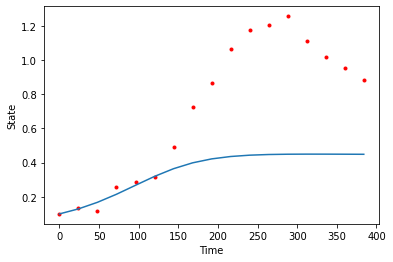

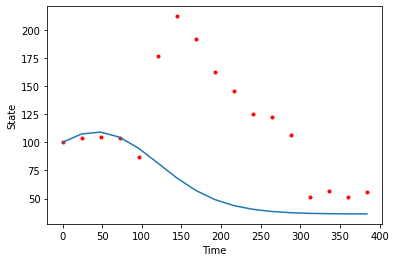

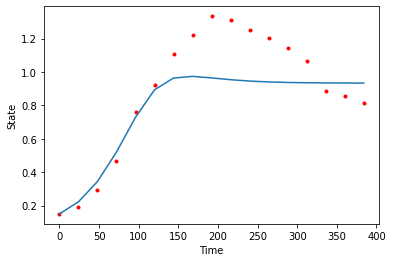

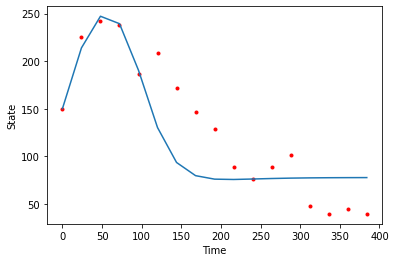

In [ ]:
check_plot(xobs2,h_xt2_exp2,tt1)

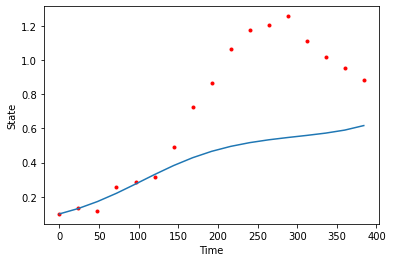

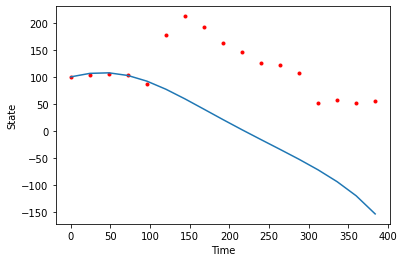

In [ ]:
check_plot(xobs1,h_xt3_exp1,tt1)

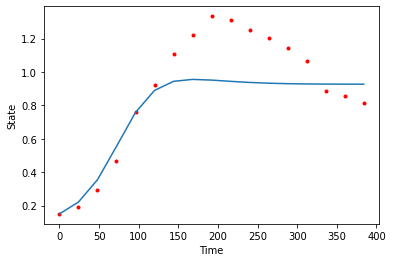

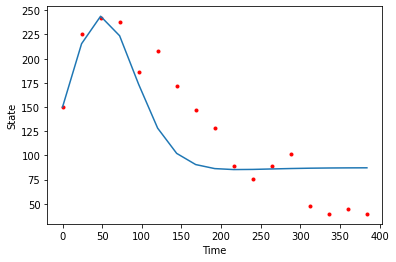

In [ ]:
check_plot(xobs2,h_xt3_exp2,tt1)